# Variational AutoEncoder

Task: Implement and train a probabilistic AutoEncoder called Variational AutoEncoder (VAE) on MNIST. A nice introduction to this topic is [here](https://www.jeremyjordan.me/variational-autoencoders/).

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [48]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(device)

batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 0.001 # TODO

epochs = 5 # TODO

cpu


In [49]:
dataset_path = 'datasets'
mnist_transform = torchvision.transforms.Compose([ torchvision.transforms.ToTensor() ]) 
train_dataset = torchvision.datasets.MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [50]:
# Implement Encoder that consists of FC input_dim -> hidden_dim, FC hidden_dim -> hidden_dim, FC hidden_dim -> latent_dim
# You can use LeakyReLU 0.2

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim * 2)

        self.lrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.lrelu(self.fc1(x))
        x = self.ln1(x)

        x = self.lrelu(self.fc2(x))
        x = self.ln2(x)

        x = self.fc3(x)

        return x 

In [51]:
# Implement Decoder that consists of FC latent_dim -> hidden_dim, FC hidden_dim -> hidden_dim, FC hidden_dim -> output_dim
# You can use Sigmoid and LeakyReLU 0.2

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.lrelu = nn.LeakyReLU(0.2)
        self.sigm = nn.Sigmoid()
        
    def forward(self, x):
        x = self.lrelu(self.fc1(x))
        x = self.ln1(x)

        x = self.lrelu(self.fc2(x))
        x = self.ln2(x)

        x = self.fc3(x)

        return self.sigm(x)

In [52]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder, latent_dim):
        super(Model, self).__init__()
        self.latent_dim = latent_dim
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, logvar):
        stddev = torch.exp(0.5 * logvar)
        eps = torch.randn_like(stddev)

        return eps * stddev + mean 
                
    def forward(self, x):
        x = self.Encoder(x)

        x_logvar = x[:, :self.latent_dim]
        x_mu = x[:, self.latent_dim:]

        assert x_logvar.shape == x_mu.shape, (x_logvar.shape, x_mu.shape)
        
        x = self.reparameterization(x_mu, x_logvar)

        x = self.Decoder(x)

        return x, x_mu, x_logvar 

In [62]:
latent_dim = int(200 / 2)

print(x_dim, hidden_dim, latent_dim)

encoder = Encoder(
    input_dim = x_dim,
    hidden_dim = hidden_dim,
    latent_dim = latent_dim,
)

decoder = Decoder(
    latent_dim = latent_dim,
    hidden_dim = hidden_dim,
    output_dim = x_dim,
)

model = Model(Encoder = encoder, Decoder = decoder, latent_dim = latent_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

784 400 100


In [ ]:
# Loss function for the Gaussian distribution prior is presented in https://arxiv.org/pdf/1907.08956.pdf, Eq. 43.

def loss_function(x, x_hat, mu, logvar):
    recons_loss = torch.nn.functional.cross_entropy(x, x_hat)

    # def ts:
        # return torch.sum(x)
    # print(ts(logvar.exp()))
    # print(ts(mu ** 2))
    # print(ts(logvar))

    kld_weight = 1.5

    KLD = torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1)
    KLD = kld_weight * torch.mean(-0.5 * KLD, dim = 0)

    print(f'{recons_loss=} {KLD=}')

    return recons_loss + KLD

In [91]:
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for i, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "Average Loss: ", overall_loss / (len(train_loader) * batch_size))

recons_loss=tensor(0.0015, grad_fn=<DivBackward1>) KLD=tensor(0.0008, grad_fn=<MeanBackward1>)
recons_loss=tensor(0.0015, grad_fn=<DivBackward1>) KLD=tensor(0.0008, grad_fn=<MeanBackward1>)
recons_loss=tensor(0.0016, grad_fn=<DivBackward1>) KLD=tensor(0.0008, grad_fn=<MeanBackward1>)
recons_loss=tensor(0.0015, grad_fn=<DivBackward1>) KLD=tensor(0.0008, grad_fn=<MeanBackward1>)
recons_loss=tensor(0.0015, grad_fn=<DivBackward1>) KLD=tensor(0.0008, grad_fn=<MeanBackward1>)
recons_loss=tensor(0.0017, grad_fn=<DivBackward1>) KLD=tensor(0.0008, grad_fn=<MeanBackward1>)
recons_loss=tensor(0.0015, grad_fn=<DivBackward1>) KLD=tensor(0.0008, grad_fn=<MeanBackward1>)
recons_loss=tensor(0.0015, grad_fn=<DivBackward1>) KLD=tensor(0.0010, grad_fn=<MeanBackward1>)
recons_loss=tensor(0.0015, grad_fn=<DivBackward1>) KLD=tensor(0.0009, grad_fn=<MeanBackward1>)
recons_loss=tensor(0.0020, grad_fn=<DivBackward1>) KLD=tensor(0.0009, grad_fn=<MeanBackward1>)
recons_loss=tensor(0.0015, grad_fn=<DivBackward1>)

KeyboardInterrupt: 

In [83]:
model.eval()

with torch.no_grad():
    for i, (x, _) in enumerate(test_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        x_hat, _, _ = model(x)
        break

In [87]:
def show_images(x, n_samples=3):
    x = x.view(batch_size, 28, 28) 
    for i in range(n_samples):
      plt.figure()
      plt.imshow(x[i].cpu().numpy())

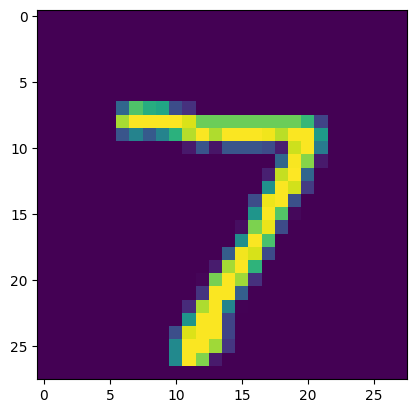

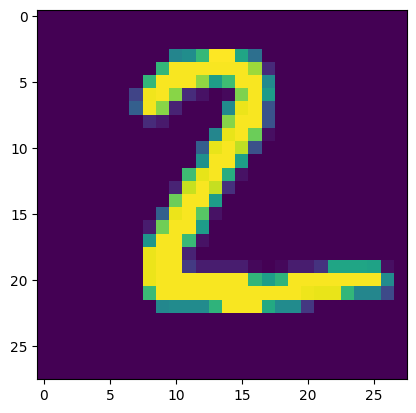

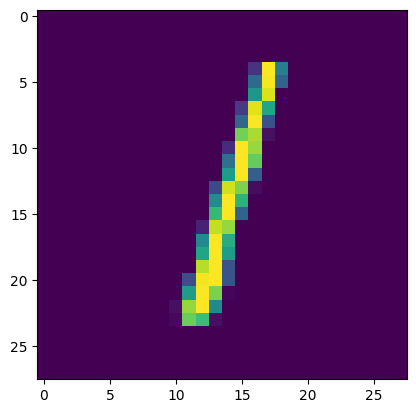

In [88]:
show_images(x)

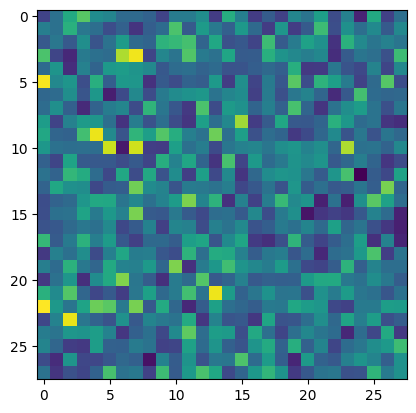

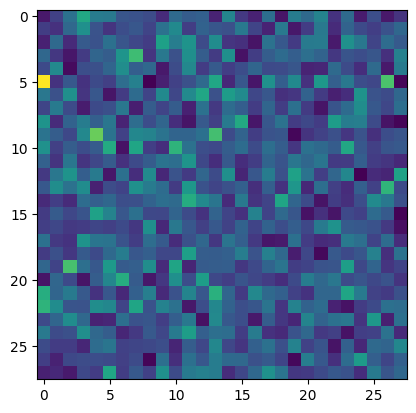

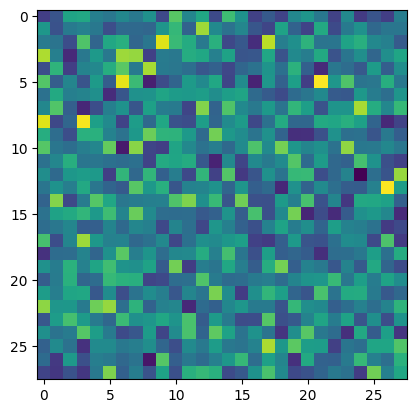

In [89]:
show_images(x_hat)

In [ ]:
# TODO: sample noise, generate new images from noise and show generted images